In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



In [2]:

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 2

DIRECTORY = r"dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.10,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
model.summary()


[INFO] loading images...


C:\Users\sabin\anaconda3\envs\gpu\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________

In [3]:

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])



checkpoint = ModelCheckpoint("model/modelmnv2.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0.001, 
                          patience = 10, 
                          verbose = 1,
                          restore_best_weights = True) 

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.001,
                              patience = 10,
                              verbose = 1,
                              min_delta = 0.001)

callbacks = [earlystop, checkpoint, reduce_lr]


# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
    callbacks = callbacks,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("model/modelmnv2.model", save_format="h5")


[INFO] training head...


C:\Users\sabin\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
2663/2663 [==============================] - 115s 40ms/step - loss: 0.2484 - accuracy: 0.9079 - val_loss: 0.0395 - val_accuracy: 0.9895

Epoch 00001: val_loss improved from inf to 0.03954, saving model to model\modelmnv2.h5
Epoch 2/20
2663/2663 [==============================] - 81s 30ms/step - loss: 0.0597 - accuracy: 0.9822 - val_loss: 0.0268 - val_accuracy: 0.9902

Epoch 00002: val_loss improved from 0.03954 to 0.02676, saving model to model\modelmnv2.h5
Epoch 3/20
2663/2663 [==============================] - 81s 30ms/step - loss: 0.0510 - accuracy: 0.9830 - val_loss: 0.0219 - val_accuracy: 0.9925

Epoch 00003: val_loss improved from 0.02676 to 0.02190, saving model to model\modelmnv2.h5
Epoch 4/20
2663/2663 [==============================] - 80s 30ms/step - loss: 0.0336 - accuracy: 0.9910 - val_loss: 0.0180 - val_accuracy: 0.9940

Epoch 00004: val_loss improved from 0.02190 to 0.01798, saving model to model\modelmnv2.h5
Epoch 5/20
2663/2663 [=============================

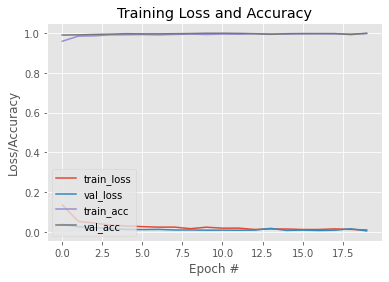

In [4]:
# plot the training loss and accuracy
N = len(H.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

Train set with_mask images= 3316      Train set without_mask images= 3342
Test set with_mask images= 663        Test set without_mask images= 668
Total number of images= 6658


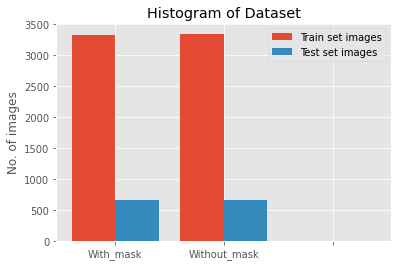

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
x=['With_mask','Without_mask','']
With_mask=os.listdir("dataset/with_mask")
Without_mask=os.listdir("dataset/without_mask")
y1=[len(With_mask),len(Without_mask),0]
y2=[int(len(With_mask)*0.2),int(len(Without_mask)*0.2),0]

xpos = np.arange(len(x))
plt.bar(xpos-0.2,y1,width=0.4, label="Train set images")
plt.bar(xpos+0.2,y2,width=0.4, label="Test set images")


plt.xticks(xpos,x)


plt.ylabel("No. of images")
plt.title('Histogram of Dataset')
plt.legend()
print("Train set with_mask images=",len(With_mask),"     Train set without_mask images=",len(Without_mask))
print("Test set with_mask images=",int(len(With_mask)*.2),"       Test set without_mask images=",int(len(Without_mask)*.2))

print("Total number of images=",len(With_mask)+len(Without_mask))
